In [1]:
import os
import numpy as np
import tensorflow as tf
# import tensorflow_hub as hub
# import tensorflow_io as tfio
import scipy.signal as sps
from scipy.io import wavfile
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
# yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
# yamnet_model = hub.load(yamnet_model_handle)
# save_dir = os.path.join(os.getcwd(), "models", "yamnet")
# if not os.path.exists(save_dir):
#     os.mkdir(save_dir)
# tf.saved_model.save(yamnet_model, save_dir)

In [3]:
model_dir = os.path.join(os.getcwd(), "models", "yamnet")
model = tf.saved_model.load(model_dir)

In [4]:
class_path = model.class_map_path().numpy().decode()
class_names = list(pd.read_csv(class_path)["display_name"])
class_names

['Speech',
 'Child speech, kid speaking',
 'Conversation',
 'Narration, monologue',
 'Babbling',
 'Speech synthesizer',
 'Shout',
 'Bellow',
 'Whoop',
 'Yell',
 'Children shouting',
 'Screaming',
 'Whispering',
 'Laughter',
 'Baby laughter',
 'Giggle',
 'Snicker',
 'Belly laugh',
 'Chuckle, chortle',
 'Crying, sobbing',
 'Baby cry, infant cry',
 'Whimper',
 'Wail, moan',
 'Sigh',
 'Singing',
 'Choir',
 'Yodeling',
 'Chant',
 'Mantra',
 'Child singing',
 'Synthetic singing',
 'Rapping',
 'Humming',
 'Groan',
 'Grunt',
 'Whistling',
 'Breathing',
 'Wheeze',
 'Snoring',
 'Gasp',
 'Pant',
 'Snort',
 'Cough',
 'Throat clearing',
 'Sneeze',
 'Sniff',
 'Run',
 'Shuffle',
 'Walk, footsteps',
 'Chewing, mastication',
 'Biting',
 'Gargling',
 'Stomach rumble',
 'Burping, eructation',
 'Hiccup',
 'Fart',
 'Hands',
 'Finger snapping',
 'Clapping',
 'Heart sounds, heartbeat',
 'Heart murmur',
 'Cheering',
 'Applause',
 'Chatter',
 'Crowd',
 'Hubbub, speech noise, speech babble',
 'Children playing'

Load RGB Data

In [32]:
def load_wav_16k_mono(fname, rate_out=16000):
    sample_rate, data = wavfile.read(fname)
    n_samples = round(len(data) * rate_out / sample_rate)
    wav = sps.resample(data, n_samples)
    return wav

def load_data_rgb_multi_class(data_dir):
    labels = []
    feature_arr = []
    red = 0
    green = 1
    blue = 2
    red_dir = os.path.join(data_dir, "red")
    green_dir = os.path.join(data_dir, "green")
    blue_dir = os.path.join(data_dir, "blue")
    red_files = [os.path.join(red_dir, fname) for fname in os.listdir(red_dir)]
    for wav_file in red_files:
        xfeatures = load_wav_16k_mono(wav_file)
        feature_arr.append(xfeatures)
        labels.append(red)
    green_files = [os.path.join(green_dir, fname) for fname in os.listdir(green_dir)]
    for wav_file in green_files:
        xfeatures = load_wav_16k_mono(wav_file)
        feature_arr.append(xfeatures)
        labels.append(green)
    blue_files = [os.path.join(blue_dir, fname) for fname in os.listdir(blue_dir)[:10]]
    for wav_file in blue_files:
        xfeatures = load_wav_16k_mono(wav_file)
        feature_arr.append(xfeatures)
        labels.append(blue)
    return np.array(feature_arr), np.array(labels)


C:\Users\csash\AppData\Local\Temp\ipykernel_15908\3856058594.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(feature_arr), np.array(labels)


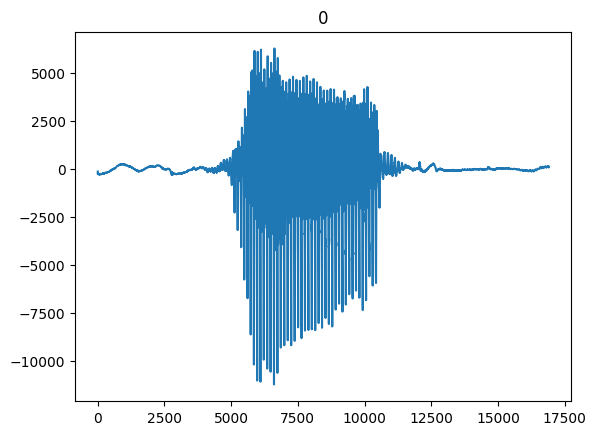

In [33]:
data_dir = os.path.join(os.getcwd(), "rgb_wavs", "rgb")

waveforms, labels = load_data_rgb_multi_class(data_dir)

waveform0, label0 = waveforms[0], labels[0]
plt.plot(waveform0)
plt.title(label0)
plt.show()

Inspecting Waveforms with Librosa

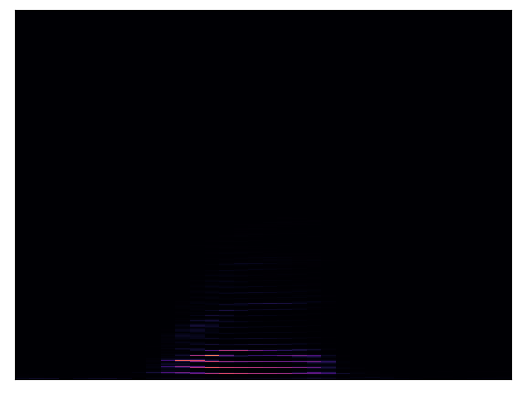

In [34]:
import librosa

spec = librosa.stft(waveform0)
mag = np.abs(spec)
librosa.display.specshow(mag)

Graph Magnitude to display features of Mel Spectrogram

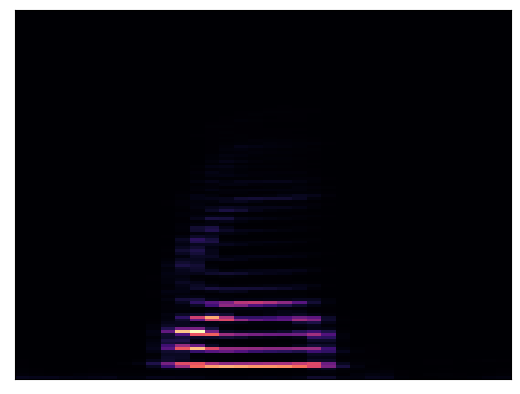

In [35]:
spec_mag, spec_phase = librosa.magphase(spec)
mel_spec = librosa.feature.melspectrogram(S=spec_mag, sr=16000)
librosa.display.specshow(mel_spec)

Graph Mel Spectrogram using Decibel Scale instead of Amplitude to visualize more spectrum being used

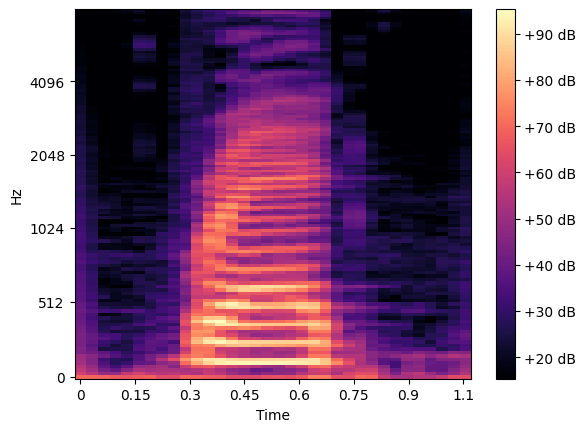

In [36]:
mel_spec = librosa.amplitude_to_db(mel_spec, ref=np.min)
librosa.display.specshow(mel_spec, sr=16000, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")

Inference with YAMNET model

In [37]:
scores, embeddings, spectrogram = model(waveform0)
class_scores = tf.reduce_mean(scores, axis=0)
top_class = tf.math.argmax(class_scores)
inferred_class = class_names[top_class]

print(f'The main sound is: {inferred_class}')
print(f'The embeddings shape: {embeddings.shape}')
print(f"Shape of spectrogram: {np.shape(spectrogram)}")

The main sound is: Speech
The embeddings shape: (2, 1024)
Shape of spectrogram: (144, 64)


(144, 64)


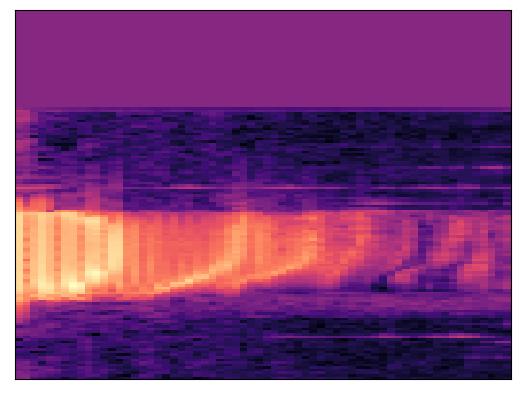

In [38]:
spec_mag = np.abs(spectrogram)
print(np.shape(spec_mag))
librosa.display.specshow(spec_mag)

Prepare RGB data for YAMNET model

In [39]:
data_shape = np.shape(waveforms)
labels_shape = np.shape(labels)
print(f"Data Shape: {data_shape}")
print(f"Labels Shape: {labels_shape}")

Data Shape: (32,)
Labels Shape: (32,)


The RGB dataset is in numpy arrays, now extract embeddings with YAMNET model

In [40]:
def extract_embedding(waveform, label):
    scores, embeddings, spectrogram = model(waveform)
    num_embed = np.shape(embeddings)[0]
    return embeddings, np.repeat(label, num_embed)

xwav = extract_embedding(waveforms[0], labels[0])
xwav


(<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
 array([[0.        , 0.04264441, 2.9373229 , ..., 0.8069628 , 0.        ,
         0.        ],
        [0.        , 0.        , 1.0324861 , ..., 0.        , 0.        ,
         0.        ]], dtype=float32)>,
 array([0, 0]))

In [44]:
data = []
data_labels = []

for waveform, label in zip(waveforms, labels):
    d, l = extract_embedding(waveform, label)
    data.extend(d)
    data_labels.extend(l)

data = np.array(data)
data_labels = np.array(data_labels)
print(np.shape(data))
print(np.shape(data_labels))

(64, 1024)
(64,)


In [46]:
rgb_model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1024), dtype=tf.float32,
                          name='input_embedding'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3)
], name='rgb_model')

rgb_model.summary()

Model: "rgb_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 526,339
Trainable params: 526,339
Non-trainable params: 0
_________________________________________________________________


In [48]:
rgb_model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=3, restore_best_weights=True)
history = rgb_model.fit(data, data_labels, epochs=40, validation_split=0.1, callbacks=callback)

Epoch 1/40
2/2 [==============================] - 0s 137ms/step - loss: 1.4086 - accuracy: 0.9123 - val_loss: 0.2444 - val_accuracy: 0.8571
Epoch 2/40
2/2 [==============================] - 0s 37ms/step - loss: 0.5597 - accuracy: 0.8947 - val_loss: 0.1015 - val_accuracy: 1.0000
Epoch 3/40
2/2 [==============================] - 0s 34ms/step - loss: 0.6742 - accuracy: 0.9649 - val_loss: 0.0781 - val_accuracy: 1.0000
Epoch 4/40
2/2 [==============================] - 0s 20ms/step - loss: 0.2915 - accuracy: 0.9474 - val_loss: 0.0757 - val_accuracy: 1.0000
Epoch 5/40
2/2 [==============================] - 0s 31ms/step - loss: 0.4133 - accuracy: 0.9474 - val_loss: 0.0935 - val_accuracy: 1.0000
Epoch 6/40
2/2 [==============================] - 0s 34ms/step - loss: 0.1573 - accuracy: 0.9649 - val_loss: 0.1365 - val_accuracy: 1.0000
Epoch 7/40
2/2 [==============================] - 0s 30ms/step - loss: 0.3498 - accuracy: 0.9649 - val_loss: 0.1623 - val_accuracy: 1.0000
Epoch 8/40
2/2 [==========

In [54]:
test_file = os.path.join(os.getcwd(), "rgb_wavs", "rgb", "blue", "blue12.wav")
test_data = load_wav_16k_mono(test_file)
class_dict = {0: "red", 1: "green", 2: "blue"}

score, embed, spec = model(test_data)
res = rgb_model(embed).numpy()
inferred_res = class_dict[res.mean(axis=0).argmax()]
print(f"Inferred Result: {inferred_res}")

Inferred Result: blue
